In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import random
from sklearn.metrics import mean_squared_error
import seaborn as sns
import statistics

## EDA

In [2]:
n = 1000000 #number of records in file
s = 1000000 #desired sample size
filename = "tick.csv"
skip = sorted(random.sample(range(n),n-s))
df = pd.read_csv(filename, header=0)

/Users/angellei/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (6,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,2016,1002894970,07/01/2016,07:35,12.0,000038,FORD,NaN,NOT GIVEN,CA,56151T1,10/31/2016,TRC7.2.40,PRK PROHIB,NaN,1231.0,MARKET,$105,NaN
1,1,2016,1003836901,07/01/2016,06:30,1.0,001871,INFI,SU,0449,CA,6TLJ220,1/14/2016,TRC7.2.42,RESTRICTED,NaN,1001.0,POTRERO,$289,NaN
2,2,2016,1004040273,07/01/2016,19:39,7.0,000910,HOND,2D,NOT GIVEN,CA,4DQY792,11/18/2016,V22500I,BUS ZONE,NaN,3274.0,24TH,$0,$409
3,3,2016,1004040284,07/01/2016,19:40,7.0,000910,TOYT,4D,NOT GIVEN,CA,5ZGU877,NaN,V22500I,BUS ZONE,NaN,3278.0,24TH,$288,NaN
4,4,2016,1004040295,07/01/2016,21:45,7.0,000910,HOND,4D,NOT GIVEN,CA,7FFM051,8/18/2016,V22500I,BUS ZONE,NaN,3018.0,MISSION,$288,NaN


In [4]:
dates = df['3']
counts = dates.value_counts().reset_index()
counts['year'] = counts['index'].apply(lambda x: x[-4:])
data = counts.sort_values(by=['year', 'index'])
data = data.rename(index=str, columns={"index": "Date",'07/01/2016': "Count"}).drop(['year'], axis=1).reset_index(drop=True)

### Using three features for my model: 'dayofweek', 'quarter', 'year'

In [5]:
data['dayofweek'] = data['Date'].apply(lambda x: pd.Timestamp(x).dayofweek)
data['quarter'] = data['Date'].apply(lambda x: pd.Timestamp(x).quarter)
data['year'] = data['Date'].apply(lambda x: pd.Timestamp(x).year)

In [8]:
quarters = pd.get_dummies(data.quarter).rename({1:'Q1',2:'Q2',3:'Q3',4:'Q4'}, axis=1)
dayofweek = pd.get_dummies(data.dayofweek).rename({0:'Mon',1:'Tues',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}, axis=1)
merged = pd.merge(data, quarters, left_index=True, right_index=True)
merged = pd.merge(merged, dayofweek, left_index=True, right_index=True).drop(['Date','dayofweek','quarter'], axis=1)

In [10]:
data['weekday'] = data.dayofweek[data['dayofweek'] < 5]
weekday = pd.get_dummies(data.weekday.values).rename({0:'Mon',1:'Tues',2:'Wed',3:'Thur',4:'Fri'}, axis=1)
weekday = pd.merge(data, weekday, left_index=True, right_index=True)
weekday = weekday.drop(['Date', 'dayofweek', 'quarter', 'year', 'weekday'], axis=1)

In [11]:
weekday = weekday.rename({'3': 'count'}, axis=1)

In [12]:
weekday.head()

,count,Mon,Tues,Wed,Thur,Fri
0,4861,0,0,0,0,1
1,1758,0,0,0,0,0
2,824,0,0,0,0,0
3,2317,1,0,0,0,0
4,4660,0,1,0,0,0


### Decided to separate the data into weekday and weekend parking tickets because I saw a huge gap between thess two groups of parking ticket.  Below is a weekday parking ticket model

Text(0, 0.5, 'Day')

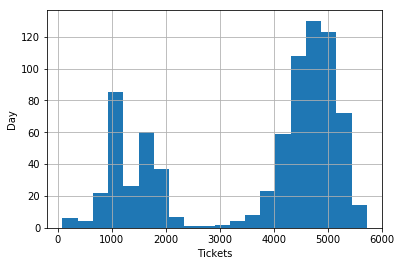

In [13]:
weekday['count'].hist(bins=20)
plt.xlabel('Tickets')
plt.ylabel('Day')

Text(0, 0.5, 'Tickets')

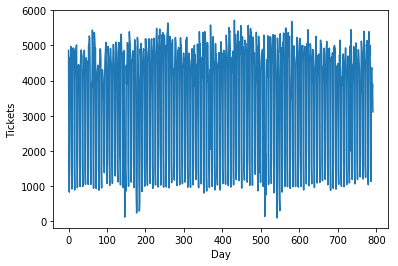

In [14]:
plt.plot(weekday['count'])
plt.xlabel('Day')
plt.ylabel('Tickets')

In [15]:
len(weekday)

792

## Linear Regression Model

In [16]:
train = weekday[:633]
test = weekday[633:]
X_train, Y_train = train[train.columns.difference(['count'])], train['count']
X_test, Y_test = test[test.columns.difference(['count'])], test['count']

In [17]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [18]:
model = lm.fit(X_train, Y_train)
train_predictions = lm.predict(X_test)

In [19]:
#coefficient for each features: Monday, Tuesday, Wednesady, Thursday, Friday

print(lm.coef_)

[3198.68131868 2611.13028083 3483.68583639 3550.54139194 3540.81916972]


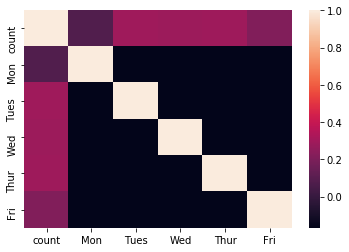

In [20]:
#Heatmap showing how correlation each independent variables to dependent variable(target)
#1.0 means highly correlated, 0.0 means is not correlated 

corr= weekday.corr()
sns.heatmap(corr)

In [21]:
x_test = X_test.index
y_test = Y_test

x_train = X_train.index
y_train = Y_train

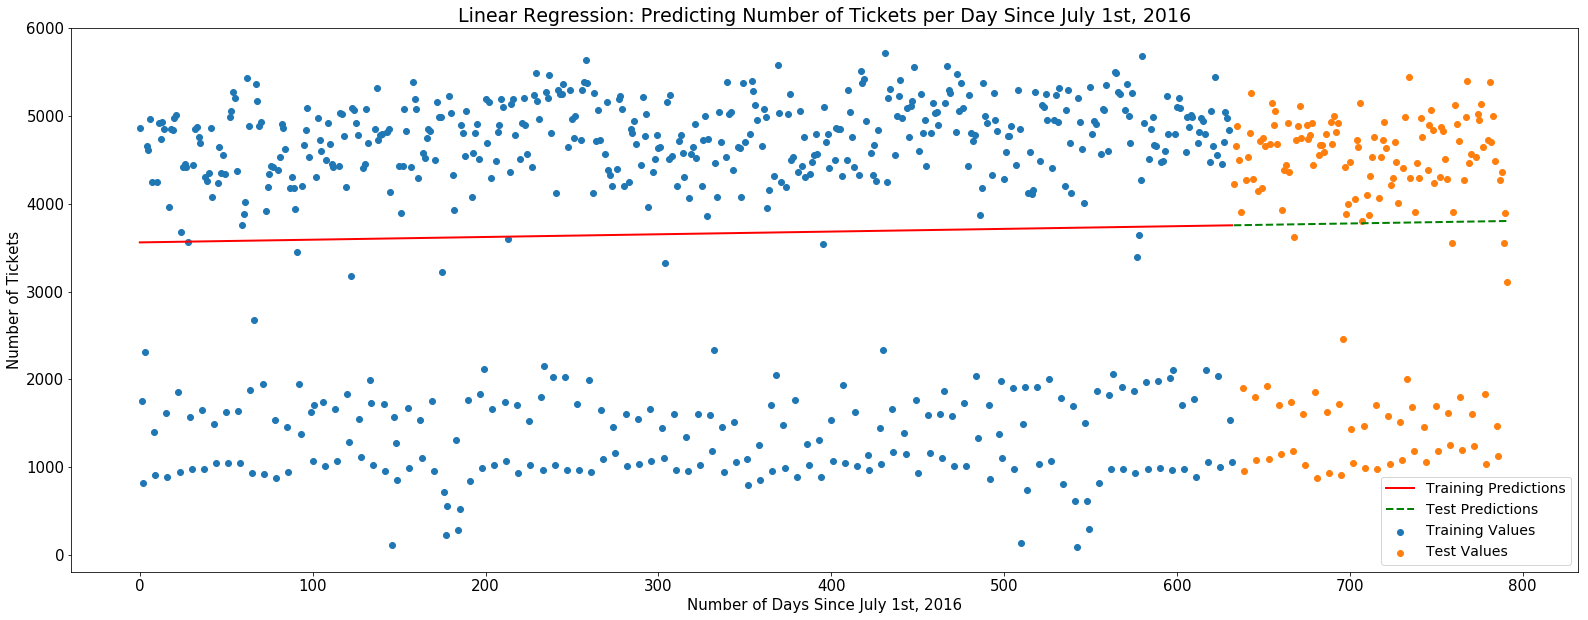

In [22]:
mn_train=min(x_train)
mx_train=max(x_train)
x1=np.linspace(mn_train,mx_train,500)

mn_train2=min(x_test)
mx_train2=max(x_test)
x2=np.linspace(mn_train2,mx_train2,500)

slope, intercept, r_value, p_value, std_err = stats.linregress(x_train,y_train)
y1=slope*x1+intercept
y2=slope*x2+intercept

plt.figure(figsize=(27,10))
plt.scatter(x_train, y_train, label="Training Values")
plt.scatter(x_test, y_test, label="Test Values")
plt.plot(x1,y1,"r-", label="Training Predictions", linewidth=2)
plt.plot(x2,y2, "g--", label="Test Predictions", linewidth=2)
plt.legend(loc="best", fontsize=14)
plt.title('Linear Regression: Predicting Number of Tickets per Day Since July 1st, 2016', fontsize=19)
plt.xlabel('Number of Days Since July 1st, 2016', fontsize=15)
plt.ylabel('Number of Tickets', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### Interpretion: Blue dot is the training dataset, Orange dot is the testing dataset
   #### Red line is is the training prediction datapoints, Green line is the testing prediction datapoints.

In [23]:
#Cross valuation score for my model, I used 5 folds. 

from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score

lin_score = cross_val_score(lm, x_train.values.reshape(-1,1), y_train, scoring='r2', cv=5)
lin_score.mean()

-0.0022598212625316804

In [24]:
zeros = np.zeros(159)
means = y_test.mean()
zero = zeros.fill(means)

In [25]:
#RMSE for baseline/benchmark

mse_baseline = np.sqrt(mean_squared_error(y_test, zeros))
mse_baseline

1485.780104140334

In [26]:
#Testing dataset's standard deviation

y_test.std()

1490.4745237497282

In [27]:
#RMSE for my model

mse = np.sqrt(mean_squared_error(y_test, train_predictions))
mse

475.54930330699517

Interpretion: Baseline RMSE is higher than testing data's standard deviation,  which means baseline is within
    my model's standard deviation. Compare my model's RMSE and baseline, my model perform much better than the 
    baseline, which means if I choose the avverage number of the parking tickets as my model, it performs worse than
    I use linear regression model to perform. 